In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json
import os, glob
from IPython.core.display import display, HTML
import logging

import warpImage
from pointAnnotator import pointAnnotator, pointCopier, points_from_path
try:
    import config as cfg
    print('loaded device specific config')
except ImportError as E:
    import default_config as cfg
    print('loaded default config')



display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

logging.basicConfig(level=logging.INFO)

loaded device specific config


In [3]:
localWarp=False

#for some reason, I find you have to run this line twice to actually take effect (depending on matplotlib version)
%matplotlib notebook 

INFO:root:\\allen/programs/braintv/production/neuralcoding/prod56/specimen_900262549/isi_experiment_910867541/910867541_target_map.tif


<IPython.core.display.Javascript object>


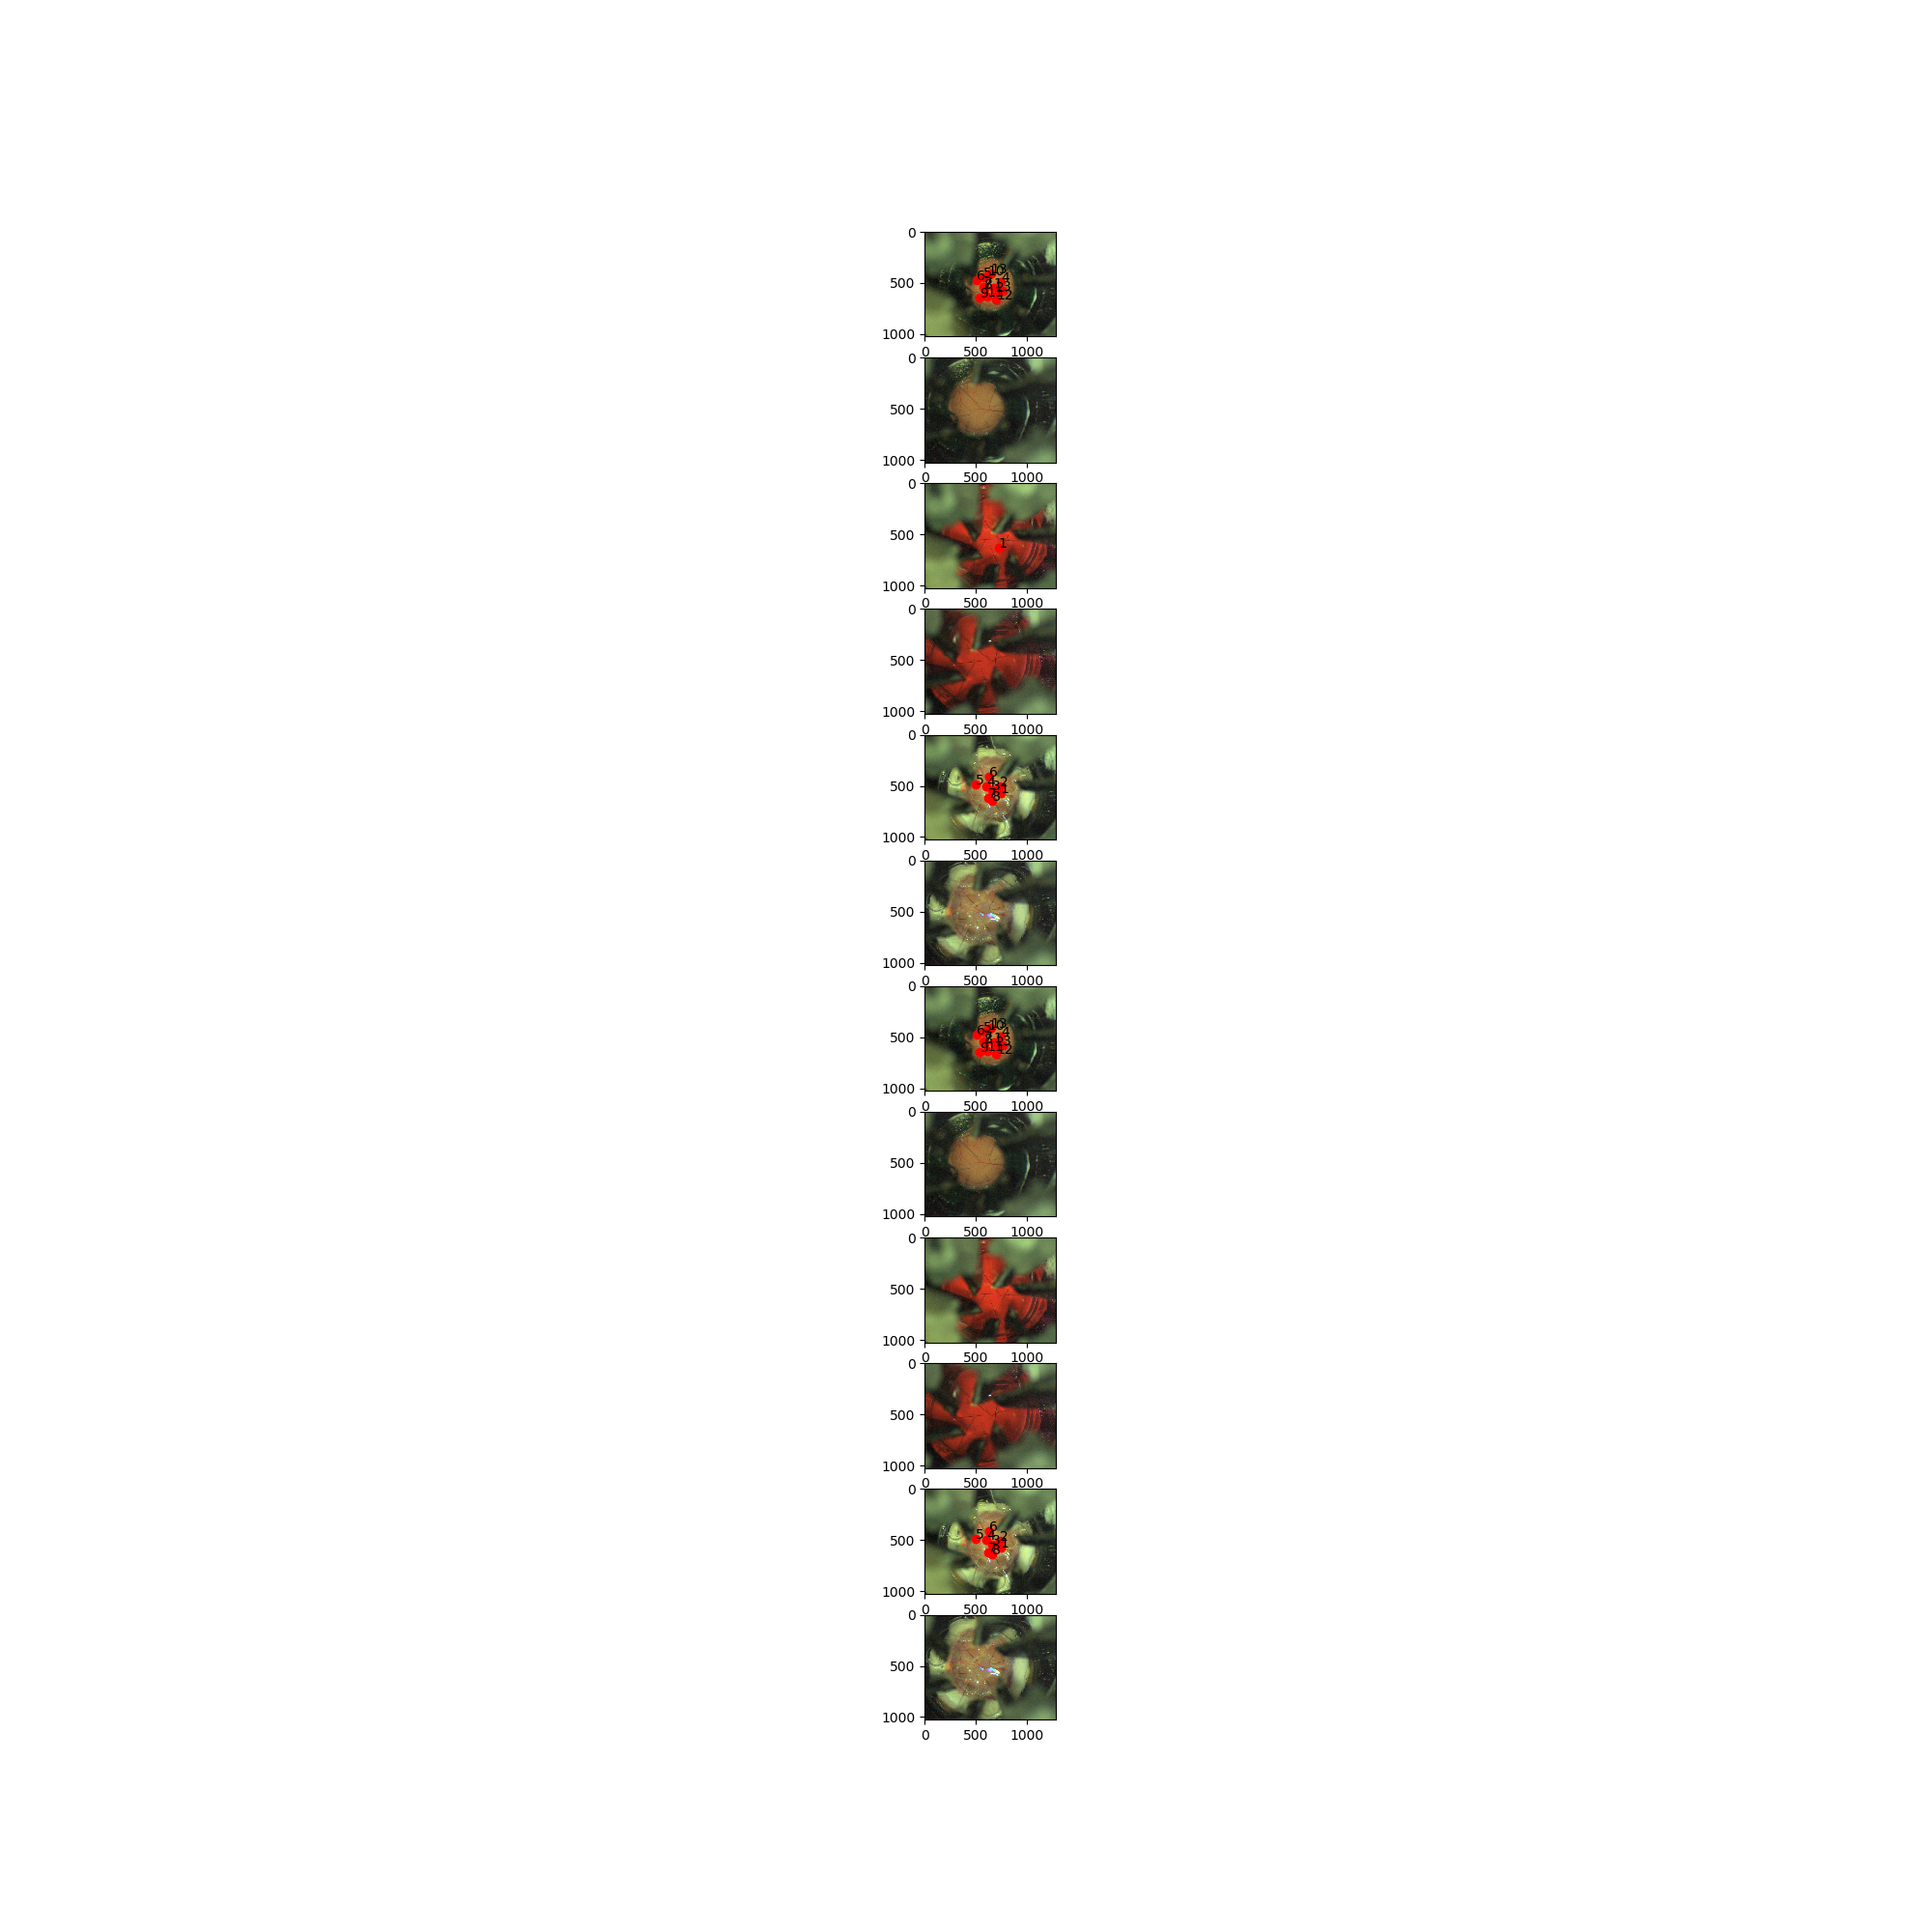

INFO:root:Z:923233917_475440_20190814\923233917_475440_20190814_surface-image1-left.png
INFO:root:Found some points
INFO:root:[[673.81885 546.40533]
 [695.2465  587.04395]
 [758.7906  573.744  ]
 [748.44617 490.2501 ]
 [574.80835 446.6559 ]
 [508.30878 475.4724 ]
 [577.7639  541.972  ]
 [579.9806  561.183  ]
 [540.0808  643.19916]
 [616.9248  422.27274]
 [607.3193  636.5492 ]
 [699.6798  665.36566]
 [645.0024  406.01727]]
INFO:root:Z:923233917_475440_20190814\923233917_475440_20190814_surface-image1-right.png
INFO:root:Z:924676209_475440_20190815\924676209_475440_20190815_surface-image1-left.png
INFO:root:Z:924676209_475440_20190815\924676209_475440_20190815_surface-image1-right.png
INFO:root:Z:924676209_475440_20190815\924676209_475440_20190815_surface-image3-left.png
INFO:root:Found some points
INFO:root:[[743.20667 574.04095]
 [734.2044  504.10037]
 [656.64655 546.3417 ]
 [601.94055 499.94547]
 [497.37592 486.09586]
 [635.1796  411.30792]
 [623.4075  619.0522 ]
 [655.2616  642.59656

In [4]:
#get path to network folder with lims images for this mouse
mouse_num = '475440'
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)
#print(info)

####################it looks like it always pulls the map with targets on it but what happens if two have targets?
vimg_path = r'\\' + info[0]['target_map_image_path'][1:]
#experiments = info[0]['isi_experiments']
#for exp in experiments:
#    if exp['targets']['insertion_targets']['reticle_space'] is not None:
#        pass

logging.info(vimg_path)

#get vasculature image
vimg = cv2.imread(vimg_path)

#get probe insertion image
pimgFileList = []#[r"Z:\03132019_416656\2019_03_13_15_11_10_left.png"]
if len(pimgFileList) == 0:
    pimgFileList = cfg.get_insertion_image_paths(mouse_num)
    
canidate_image_count = len(pimgFileList)

pimg_dict = {}
ppa_dict = {}
points_dict = {}


if canidate_image_count > 1:
    fig, ax = plt.subplots(canidate_image_count, figsize=(20,20))#/(2*aspect)))
    for idx, image_path in enumerate(pimgFileList):
        next_ax = ax[idx]
        logging.info(image_path)
        next_image = cv2.imread(image_path)
        next_image = next_image[:, :, [2,1,0]]
        pimg_dict[image_path] = next_ax.imshow(next_image, origin='upper')
        ppa_dict[image_path] = pointAnnotator(pimg_dict[image_path], next_ax)
        directory_path, image_name = os.path.split(image_path)
        points_dict[image_path] = points_from_path(directory_path, image_name, 'landmark_points')
        ppa_dict[image_path].loadPoints(points_dict[image_path])

INFO:root:1


<IPython.core.display.Javascript object>


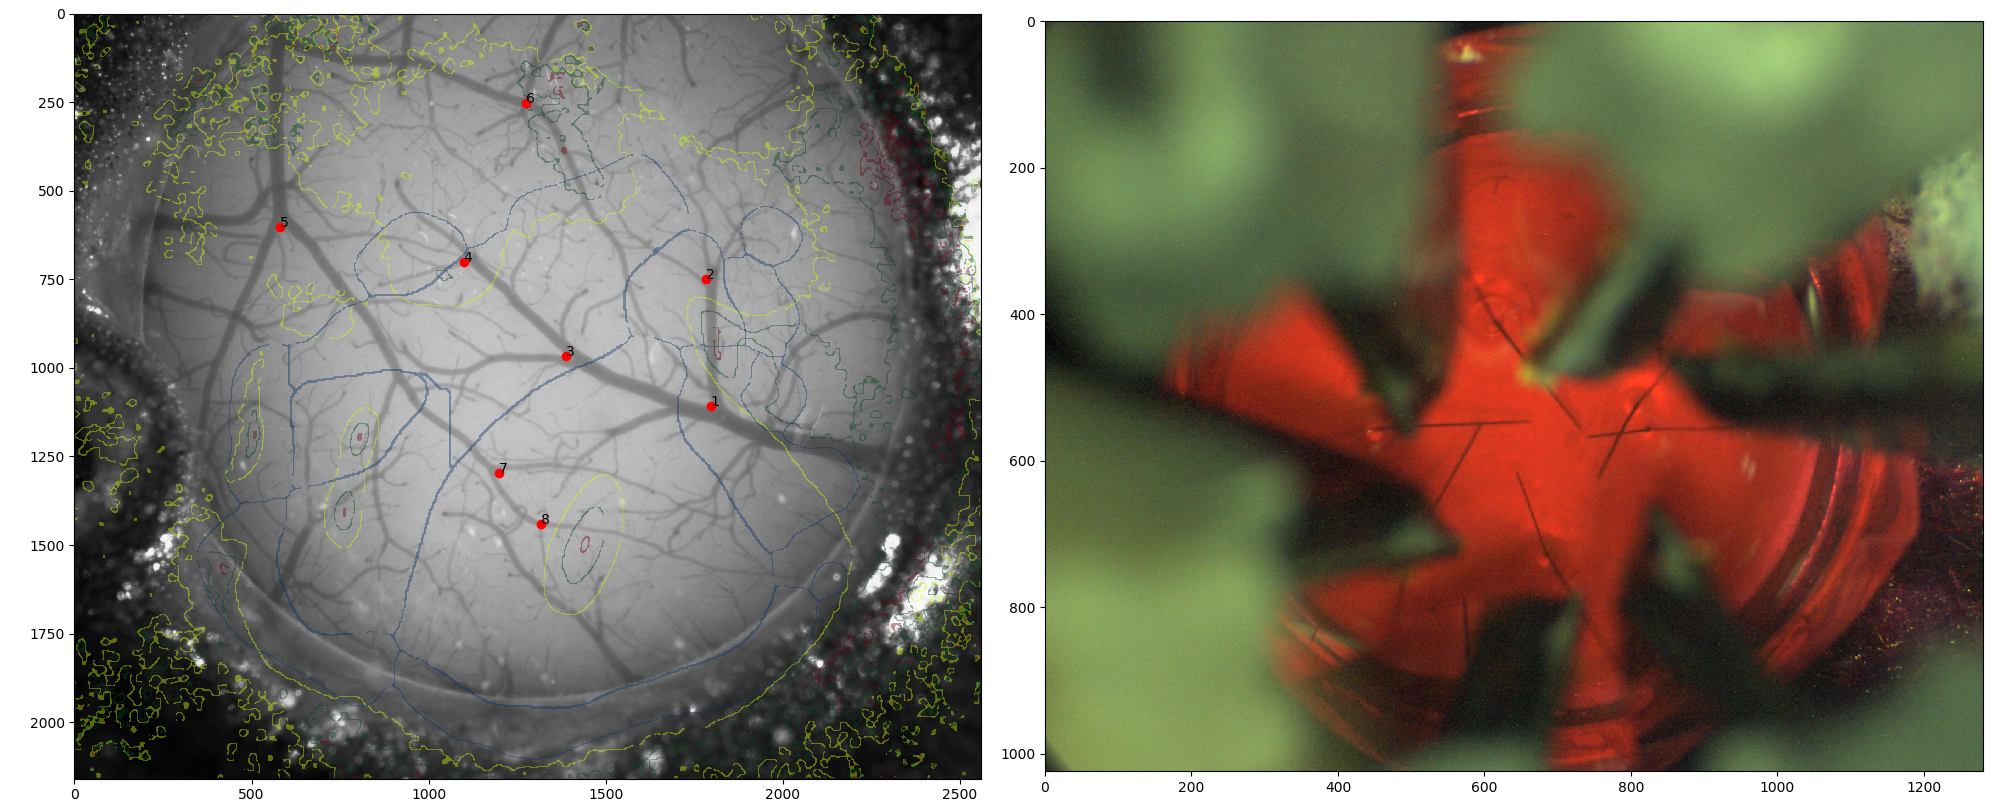

INFO:root:Found some points
INFO:root:[[1796.641   1106.5817 ]
 [1782.5203   747.91736]
 [1387.1423   965.37524]
 [1099.0812   699.90717]
 [ 579.4416   601.0627 ]
 [1274.1771   250.87074]
 [1197.9257  1295.7983 ]
 [1316.5391  1439.8289 ]]


In [5]:
#Display the vasculature images and select points of interest (at least three)

if canidate_image_count > 1:
    count = 0
    for image_path, annotator in ppa_dict.items():
        if not(np.array_equal(annotator.points, points_dict[image_path])):
            count+=1
            logging.info(count)
            chosen_image_path = image_path
    try:
        assert(count==1)
    except AssertionError as E:
        logging.error('Image chosen is ambiguous, none or multiple were clicked. Please reset and try again.')
        raise(E)
    pimg_path = chosen_image_path
else:
    pimg_path = pimgFileList[0]

pimg = cv2.imread(pimg_path)
chosen_probe_image_name = os.path.split(pimg_path)[1]
chosen_vasculature_image_name = os.path.split(vimg_path)[1]

#change from opencv bgr default back to rgb
pimg = pimg[:, :, [2,1,0]]
vimg = vimg[:, :, [2,1,0]]
aspect = (pimg.shape[0]+vimg.shape[0])/float(np.max([pimg.shape[1], vimg.shape[1]]))

fig, ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
vax = ax[0]
pax = ax[1]

vim = vax.imshow(vimg, origin='upper')
vpa = pointAnnotator(vim, vax)
vasculature_landmark_points = points_from_path(pimg_path, chosen_vasculature_image_name, 'landmark')
vpa.loadPoints(vasculature_landmark_points)

pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)
probe_landmark_points = points_from_path(pimg_path, chosen_probe_image_name, 'landmark')
ppa.loadPoints(probe_landmark_points)

plt.tight_layout(pad=1, w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


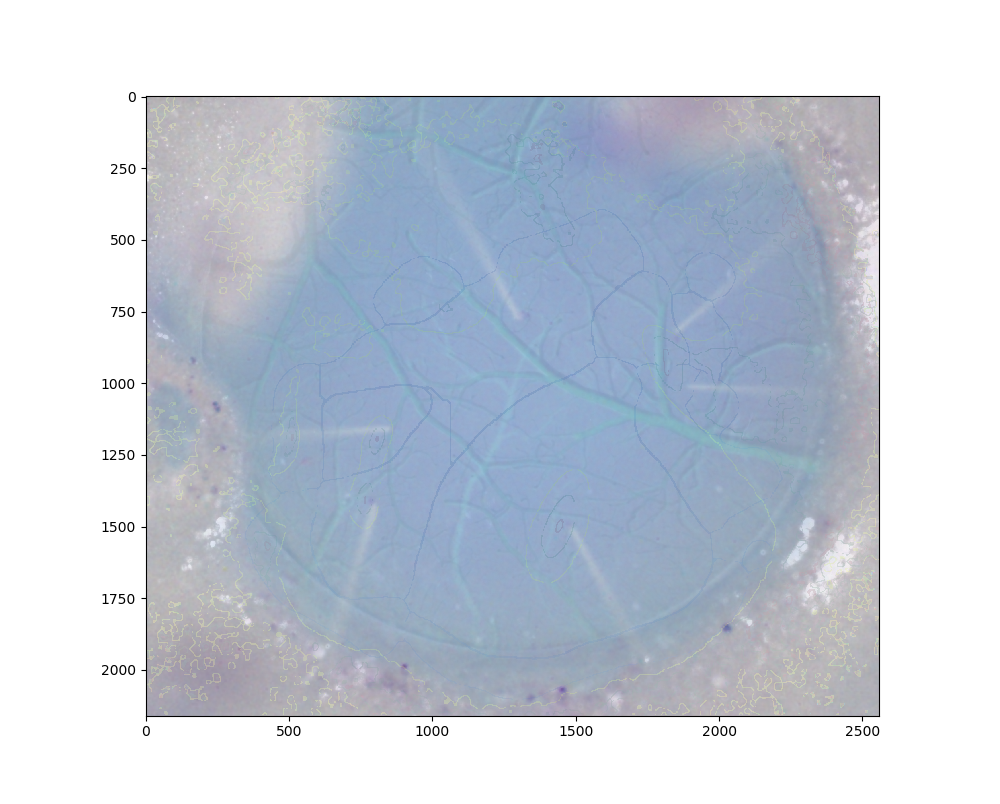

In [8]:
#Compute affine transform to warp probe insertion image to vasculature image coordinates

#reshape points into [numpoints, 2] arrays
ppoints = ppa.points #np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
vpoints = vpa.points #np.stack((vpa.xs, vpa.ys)).astype(np.float32).T

#get perspective transform between images and apply it to probe insertion image
perspective = cv2.findHomography(ppoints, vpoints)
pimg_transform = cv2.warpPerspective(pimg, perspective[0], (vimg.shape[1], vimg.shape[0]))

#transform probe insertion points to use in local warping or plot on transformed image
ppoints_transform = cv2.perspectiveTransform(np.array([ppoints.astype(np.float32)]), perspective[0])
ppoints_transform = np.squeeze(ppoints_transform)

#perform Delaunay triangle local warp if specified
if localWarp:
    pimg_transform = warpImage.warpImage(vimg, pimg_transform, vpoints, ppoints_transform)

#plot overlay of vasculature image and transformed image to compare
fig, ax = plt.subplots(figsize=(10,10/aspect))
ax.imshow(vimg, alpha=0.5)
ax.imshow(255-pimg_transform, alpha=0.5)


<IPython.core.display.Javascript object>


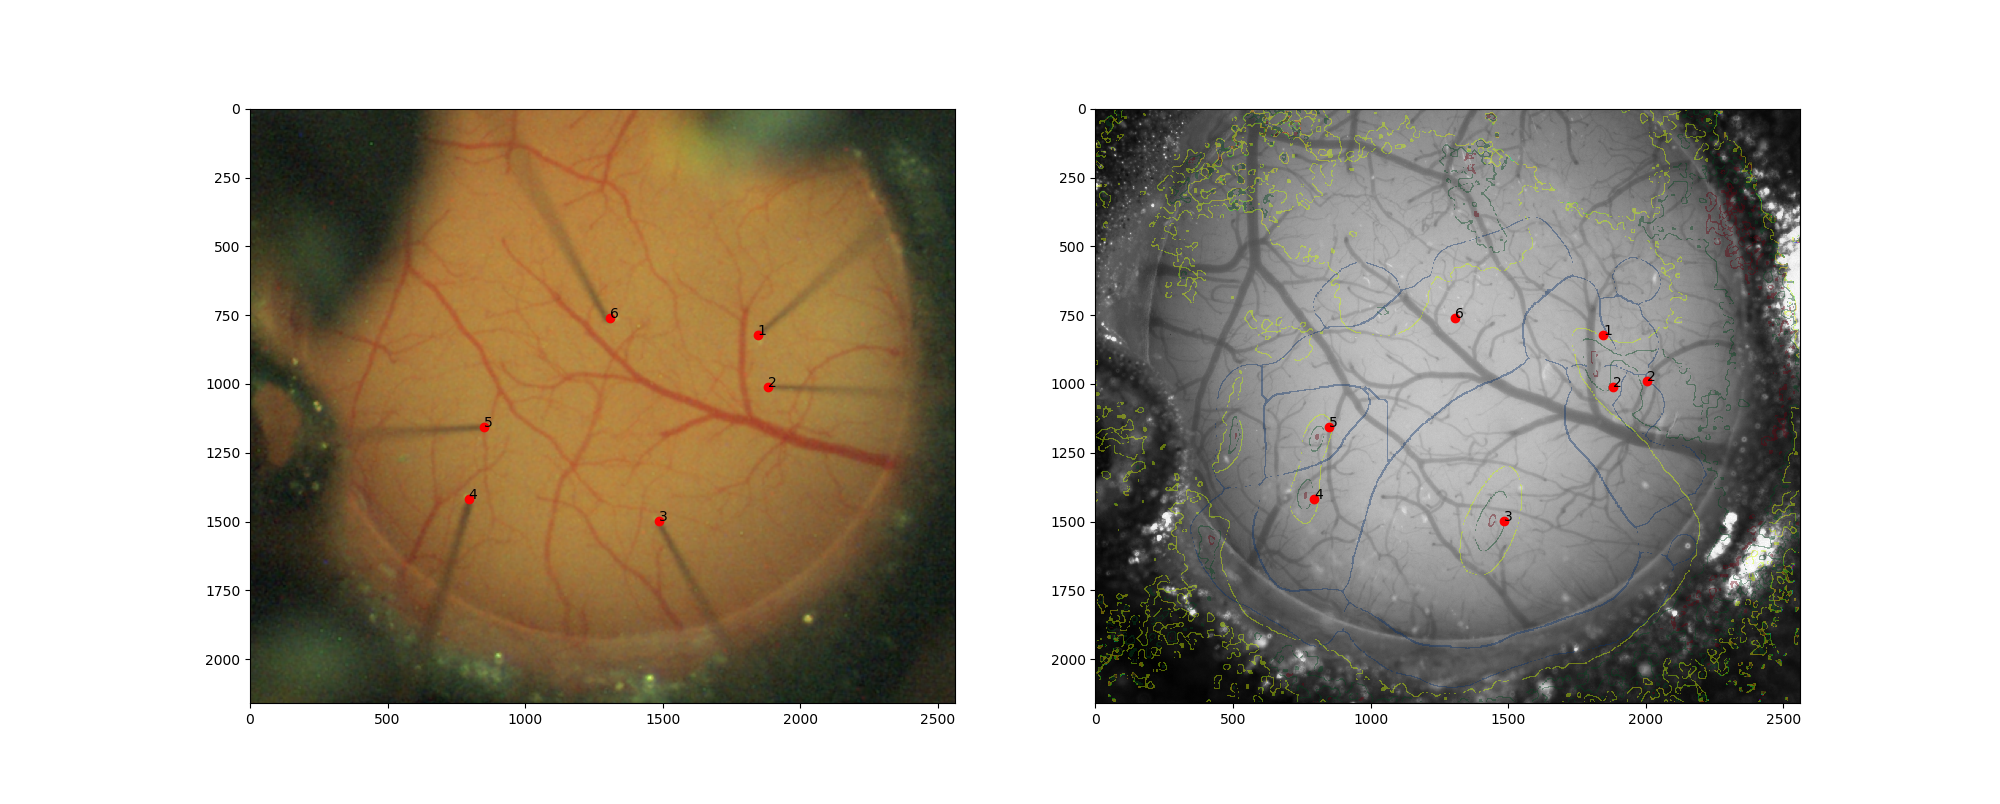

In [10]:
#Select location of probe insertion points in this warped image
fig, ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
paffax = ax[0]
vax2 = ax[1]

paff_im = paffax.imshow(pimg_transform, origin='upper')
paffp = pointAnnotator(paff_im, paffax)
probe_insertion_points = points_from_path(pimg_path, chosen_vasculature_image_name, chosen_probe_image_name, 'insertion')
paffp.loadPoints(probe_insertion_points)

#paffpoints = paffp.points  # np.stack((paffp.xs, paffp.ys)).astype(np.float32).T


vim2 = vax2.imshow(vimg, origin='upper')
vpa = pointCopier(vim2, vax2, paffax)
vpa.loadPoints(probe_insertion_points)

In [21]:
print(paffp.points)

[[1844.5708   821.4971 ]
 [1880.9062  1010.4416 ]
 [1484.8495  1497.337  ]
 [ 794.47534 1417.399  ]
 [ 848.9786  1155.7836 ]
 [1306.8057   759.72675]]


In [18]:
# save points and transformation matrix
save_path = cfg.get_save_path(pimg_path)
try:
    current_npz = np.load(save_path)
    save_dict = dict(current_npz)
except IOError as E:
    save_dict = {}

save_dict['vasculatureImageKeypoints'] = vpoints
save_dict['probeImageKeypoints'] = ppoints
save_dict['vasculatureToProbeInsertionTransform'] = perspective[0]
save_dict['probeInsertionPointsTransformed'] = paffp.points
save_dict[chosen_vasculature_image_name+'_landmark_points'] = vpoints
save_dict[chosen_probe_image_name+'_landmark_points'] = ppoints
save_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_transform'] = perspective[0]
save_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_insertion_points'] = paffp.points

np.savez(save_path, **save_dict)



In [12]:
# save notebook as html
saveDirectory = os.path.dirname(pimg_path)
os.system('jupyter nbconvert probeInsertionLocator.ipynb --output ' + os.path.join(saveDirectory, 'probeInsertionNotebook.html'))

0